### 第二章 作业1

1.单位平方度内，有多少r<20.5 mag 的星系？

In [1]:
import numpy as np
from scipy.integrate import quad
from astropy.cosmology import FlatLambdaCDM, z_at_value
from astropy.constants import c
from astropy import units as u

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

phi_star = 1.46e-2  # h^3 Mpc^-3
M_star = -20.83
alpha = -1.20
r_lim = 20.5

def schechter(M, M_star, phi_star, alpha):
    factor = 0.4 * np.log(10) * phi_star
    term1 = 10**(0.4 * (M_star - M) * (alpha + 1))
    term2 = np.exp(-10**(0.4 * (M_star - M)))
    return factor * term1 * term2

def absolute_magnitude_limit(z, r_lim):
    Dl = cosmo.luminosity_distance(z).to(u.pc).value
    return r_lim - 5 * np.log10(Dl / 10)

# The differential comoving volume element dV_c/dz/dSolidAngle.
def dV_dOmega_dz(z):
    return cosmo.differential_comoving_volume(z).value

def number_density_per_sq_degree():
    z_max = 1
    def integrand(z):
        M_lim = absolute_magnitude_limit(z, r_lim)
        M_min = -30  # 低光度极限
        # 对光度函数积分
        phi_integral, _ = quad(schechter, M_min, M_lim, args=(M_star, phi_star, alpha))
        # 乘以体积元素
        return phi_integral * dV_dOmega_dz(z)
    result, _ = quad(integrand, 0, z_max)
    return result * (np.pi / 180)**2

N_per_sq_degree = number_density_per_sq_degree()
print(f"单位平方度内 r < 20.5 的星系数量为: {N_per_sq_degree:.2f}")

单位平方度内 r < 20.5 的星系数量为: 3596.56


2.SDSS给出的本地星系的Schechter光度函数的参数为Mr*=-20.83，α=-1.0，请问单位体积范围内Mr=-16mag的星系数目是Mr=-22mag星系数目的多少倍？SDSS是星等极限样本（r<17.77）,请问在SDSS的观测样本中， Mr=-22 mag的星系数目是Mr=-16mag星系数目的多少倍？

In [2]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
phi_star = 1.46e-2
M_star = -20.83
alpha = -1.0
M_r_1 = -22
M_r_2 = -16

# 计算单位体积中的星系数量比\phi(M1) / \phi(M2)
def volume_density_ratio(M1, M2):
    phi1 = schechter(M1, M_star, phi_star, alpha)
    phi2 = schechter(M2, M_star, phi_star, alpha)
    return phi1 / phi2

R_volume = volume_density_ratio(M_r_1, M_r_2)
print(f"单位体积内 M_r = -22 星系数目比是 M_r = -16 星系数目比的 {R_volume:.4f} 倍")


单位体积内 M_r = -22 星系数目比是 M_r = -16 星系数目比的 0.0536 倍


In [3]:
def max_redshift(M_r, r_limit):
    """
    r = M_r + 5 \log_{10}(D_L / 10 pc)
    D_L = 10^{(r - M_r)/5 + 1}
    """
    D_L = (10 ** ((r_limit - M_r) / 5 + 1)) * u.pc  # 光度距离 (pc)
    z_max = z_at_value(cosmo.luminosity_distance, D_L.to(u.Mpc), zmax=5)  # 转换为 Mpc
    return z_max

def observed_density_ratio(M_r_1, M_r_2, r_limit, M_star, phi_star, alpha):
    z_max_1 = max_redshift(M_r_1, r_limit)
    z_max_2 = max_redshift(M_r_2, r_limit)
    def integrand(z, M_r):
        phi = schechter(M_r, M_star, phi_star, alpha)
        volume_element = cosmo.differential_comoving_volume(z).value  # 单位: Mpc^3/sr/dz
        return phi * volume_element
    
    N1, _ = quad(integrand, 0, z_max_1, args=(M_r_1,))
    N2, _ = quad(integrand, 0, z_max_2, args=(M_r_2,))
    return N1 / N2

phi_star = 1.46e-2
M_star = -20.83
alpha = -1.0
r_limit = 17.77
M_r_1 = -22
M_r_2 = -16
R_observed = observed_density_ratio(M_r_1=M_r_1, M_r_2=M_r_2, r_limit=r_limit, 
                                   M_star=M_star, phi_star=phi_star, alpha=alpha)

print(f"SDSS 观测样本中 M_r = -22 mag 的星系数量是 M_r = -16 mag 星系数量的 {R_observed:.4f} 倍")

SDSS 观测样本中 M_r = -22 mag 的星系数量是 M_r = -16 mag 星系数量的 133.3253 倍


In [ ]:
# good~

3. 根据以上光度函数，画出一个Mr=-22 mag星系的红移分布概率（不考虑星系的K改正和演化效应）

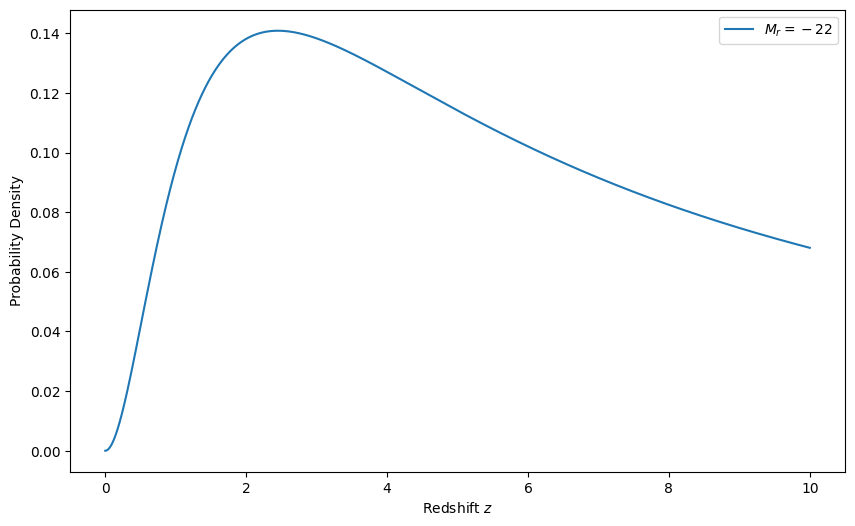

In [4]:
import matplotlib.pyplot as plt
M_target = -22
M_star = -20.83
z_min = 0.0
z_max = 10.0
num_z = 10000
z = np.linspace(z_min, z_max, num_z)
# 体积元
dV_dz = cosmo.differential_comoving_volume(z).value
n_M = schechter(M_target, M_star, phi_star, alpha)

h = 0.7
n_M = n_M / h**3
sky_area = 4 * np.pi
N_z = n_M * dV_dz * sky_area  # 星系数目 / z
prob_z = N_z / np.trapz(N_z, z)

plt.figure(figsize=(10, 6))
plt.plot(z, prob_z, label=r'$M_r = -22$')
plt.xlabel('Redshift $z$')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

### 第二章 作业2

某旋涡星系和椭圆星系，其观测到的I波段的视星等都是18等；半光度半径内的表面亮度都是20mag/arcsec^2；其中旋涡星系（图像椭率为0.5 ）观测得到的HI的速度展宽是200km/s，椭圆星系观测到的中心速度弥散度是200km/s，请问这两个星系的距离分别是多少？

In [5]:
m_spiral = 18
sfb_spiral = 20
sigma_HI_spiral = 200

# 椭率e=0.5, 倾角sin i = 1-e = 0.5
W_spiral = sigma_HI_spiral / 0.5
# TF关系
# 根据课件里的近似取a=2.4/-20.4, b=-19
M_spiral = (2.4/(-20.4)) * np.log(W_spiral) - 19

d_spiral = 10**((m_spiral - M_spiral)/5 + 1)
print("旋涡星系距离：", (d_spiral*u.pc).to(u.Mpc))

旋涡星系距离： 347.51666546986405 Mpc


In [6]:
# 椭圆星系绝对星等根据表面亮度和绝对星等的基本面得到大致约为-23等
m_ellipse = 18
M_ellipse = -23
d_ellipse = 10**((m_ellipse - M_ellipse)/5 + 1)
print("椭圆星系距离：", (d_ellipse*u.pc).to(u.Mpc))

椭圆星系距离： 1584.8931924611109 Mpc


2. 旋涡星系的 Tully-Fisher关系以及椭圆星系的Fundamental Plane的内秉弥散在0.2个星等左右，请问以上距离计算的误差是多少？

主要计算公式就是$10^{(5\times x)}$进行误差传递，x为星等差，单位为mag，基本面给出弥散为0.2mag

对这个公式求导得到$5 \times\ln(10)\times 10^{(5x)}\times \Delta x$

In [7]:
def error_prop(x):
    return np.log(10) * 10**x * (0.2/5) 

x_ellipse = (m_ellipse - M_ellipse) / 5 + 1
delta_x = 0.2 / 5  # 假设 Δ(m - M) = 0.2
print("椭圆星系距离误差：", (error_prop(x_ellipse) * u.pc).to(u.Mpc))

x_spiral = (m_spiral - M_spiral) / 5 + 1
print("旋涡星系距离误差：", (error_prop(x_spiral) * u.pc).to(u.Mpc))

椭圆星系距离误差： 145.97405755794787 Mpc
旋涡星系距离误差： 32.00746773911631 Mpc
